# Explore here

In [29]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import *
from imblearn.metrics import specificity_score
import requests
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from pickle import dump
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import classification_report
import re
from sklearn.neighbors import KNeighborsClassifier
from statsmodels.tsa.stattools import adfuller
from pmdarima import auto_arima
import seaborn as sns

In [3]:
'''
url = "https://raw.githubusercontent.com/4GeeksAcademy/alternative-time-series-project/main/sales.csv"
response = requests.get(url).content.decode('utf-8')

file_name_m = '../data/raw/sales.csv'

with open(file_name_m, 'w') as temp_file:
    temp_file.writelines(response)
'''

'\nurl = "https://raw.githubusercontent.com/4GeeksAcademy/alternative-time-series-project/main/sales.csv"\nresponse = requests.get(url).content.decode(\'utf-8\')\n\nfile_name_m = \'../data/raw/sales.csv\'\n\nwith open(file_name_m, \'w\') as temp_file:\n    temp_file.writelines(response)\n'

In [4]:
file_name = '../data/raw/sales.csv'
df = pd.read_csv(file_name)
pd.set_option('display.max_columns', None)

In [5]:
df.head()

,date,sales
0,2022-09-03 17:10:08.079328,55.292157
1,2022-09-04 17:10:08.079328,53.803211
2,2022-09-05 17:10:08.079328,58.141693
3,2022-09-06 17:10:08.079328,64.530899
4,2022-09-07 17:10:08.079328,66.013633


In [6]:
df.dtypes

date      object
sales    float64
dtype: object

In [7]:
df.isna().sum()

date     0
sales    0
dtype: int64

In [8]:
df.nunique()

date     366
sales    366
dtype: int64

In [9]:
df.shape

(366, 2)

Observamos que no hay valores nulos, ni tampoco campos vacíos, ya que hay tantos valores por producto y fecha como tamaño del dataframe.

In [10]:
df.date = pd.to_datetime(df.date)
df.dtypes

date     datetime64[ns]
sales           float64
dtype: object

In [11]:
(df.date.max()-df.date.min()).days

365

In [12]:
df.date.nunique()

366

Observamos como se trata de los datos a lo largo de un año, con un valor por día.

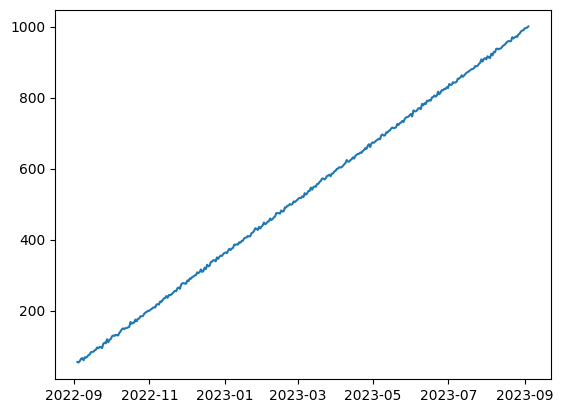

In [13]:
plt.plot(df.date, df.sales)

In [14]:
df.date

0     2022-09-03 17:10:08.079328
1     2022-09-04 17:10:08.079328
2     2022-09-05 17:10:08.079328
3     2022-09-06 17:10:08.079328
4     2022-09-07 17:10:08.079328
                 ...            
361   2023-08-30 17:10:08.079328
362   2023-08-31 17:10:08.079328
363   2023-09-01 17:10:08.079328
364   2023-09-02 17:10:08.079328
365   2023-09-03 17:10:08.079328
Name: date, Length: 366, dtype: datetime64[ns]

¿Cuál es el tensor de la serie temporal? El tensor es un día natural.

¿Cuál es la tendencia? Ascendente

¿Es estacionaria? No

¿Existe variabilidad o presencia de ruido? No hay variabilidad estacional y el ruido es mínimo.

In [15]:
def test_stationarity(timeseries):
    print("Resultados de la prueba de Dickey-Fuller:")
    dftest = adfuller(timeseries, autolag = "AIC")
    dfoutput = pd.Series(dftest[0:4], index = ["Test Statistic", "p-value", "#Lags Used", "Number of Observations Used"])
    for key,value in dftest[4].items():
        dfoutput["Critical Value (%s)"%key] = value
    return dfoutput

In [22]:
total_data = df.set_index("date")
ts = total_data["sales"]
ts.head()


date
2022-09-03 17:10:08.079328    55.292157
2022-09-04 17:10:08.079328    53.803211
2022-09-05 17:10:08.079328    58.141693
2022-09-06 17:10:08.079328    64.530899
2022-09-07 17:10:08.079328    66.013633
Name: sales, dtype: float64

In [ ]:
test_stationarity(ts)

Resultados de la prueba de Dickey-Fuller:


Test Statistic                   0.545414
p-value                          0.986190
#Lags Used                      13.000000
Number of Observations Used    352.000000
Critical Value (1%)             -3.449065
Critical Value (5%)             -2.869786
Critical Value (10%)            -2.571163
dtype: float64

Aquí podemos ver que el p-value es mayor a 0.05, esto significa que nuestra hipótesis nula será rechazada y tomaremos esta serie como no estacionaria.

Pasamos a convertirla a estacionaria.

In [26]:
ts_stationary = ts.diff().dropna()

test_stationarity(ts_stationary)

Resultados de la prueba de Dickey-Fuller:


Test Statistic                -9.430263e+00
p-value                        5.212954e-16
#Lags Used                     1.200000e+01
Number of Observations Used    3.520000e+02
Critical Value (1%)           -3.449065e+00
Critical Value (5%)           -2.869786e+00
Critical Value (10%)          -2.571163e+00
dtype: float64

Aquí podemos ver que el p-value es menor a 0.05, esto significa que nuestra hipótesis nula es aceptada y tomaremos esta serie como estacionaria.

In [27]:
model = auto_arima(ts_stationary, seasonal = True, trace = True, m = 12)

/home/vscode/.local/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/vscode/.local/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/vscode/.local/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/vscode/.local/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/vscode/.local/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(1,0,1)[12] intercept   : AIC=1847.119, Time=1.09 sec
 ARIMA(0,0,0)(0,0,0)[12] intercept   : AIC=2096.542, Time=0.01 sec


/home/vscode/.local/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/vscode/.local/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,0,0)(1,0,0)[12] intercept   : AIC=1972.854, Time=0.20 sec


/home/vscode/.local/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,0,1)(0,0,1)[12] intercept   : AIC=inf, Time=0.51 sec
 ARIMA(0,0,0)(0,0,0)[12]             : AIC=2209.657, Time=0.01 sec


/home/vscode/.local/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/vscode/.local/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,0,2)(0,0,1)[12] intercept   : AIC=1845.127, Time=0.61 sec


/home/vscode/.local/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,0,2)(0,0,0)[12] intercept   : AIC=1843.049, Time=0.35 sec


/home/vscode/.local/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,0,2)(1,0,0)[12] intercept   : AIC=1845.092, Time=0.83 sec


/home/vscode/.local/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,0,2)(0,0,0)[12] intercept   : AIC=1843.587, Time=0.22 sec


/home/vscode/.local/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,0,1)(0,0,0)[12] intercept   : AIC=1841.533, Time=0.54 sec


/home/vscode/.local/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,0,1)(1,0,0)[12] intercept   : AIC=1843.436, Time=1.00 sec


/home/vscode/.local/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,0,1)(0,0,1)[12] intercept   : AIC=1843.433, Time=0.80 sec


/home/vscode/.local/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,0,1)(1,0,1)[12] intercept   : AIC=inf, Time=1.09 sec
 ARIMA(1,0,1)(0,0,0)[12] intercept   : AIC=1839.553, Time=0.18 sec


/home/vscode/.local/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/vscode/.local/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,0,1)(1,0,0)[12] intercept   : AIC=1841.455, Time=0.55 sec


/home/vscode/.local/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,0,1)(0,0,1)[12] intercept   : AIC=1841.455, Time=0.34 sec


/home/vscode/.local/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,0,1)(1,0,1)[12] intercept   : AIC=1843.455, Time=0.77 sec
 ARIMA(0,0,1)(0,0,0)[12] intercept   : AIC=1839.587, Time=0.09 sec
 ARIMA(1,0,0)(0,0,0)[12] intercept   : AIC=1970.972, Time=0.03 sec


/home/vscode/.local/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/vscode/.local/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/vscode/.local/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,0,2)(0,0,0)[12] intercept   : AIC=1839.608, Time=0.25 sec
 ARIMA(2,0,0)(0,0,0)[12] intercept   : AIC=1922.649, Time=0.11 sec


/home/vscode/.local/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/vscode/.local/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,0,1)(0,0,0)[12]             : AIC=inf, Time=0.26 sec

Best model:  ARIMA(1,0,1)(0,0,0)[12] intercept
Total fit time: 9.863 seconds


Los hiperparámetros más optimos para el modelo de Arima son:

Best model:  ARIMA(1,0,1)

In [28]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  365
Model:               SARIMAX(1, 0, 1)   Log Likelihood                -915.776
Date:                Thu, 06 Feb 2025   AIC                           1839.553
Time:                        16:31:31   BIC                           1855.152
Sample:                    09-04-2022   HQIC                          1845.752
                         - 09-03-2023                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      2.8110      0.134     21.055      0.000       2.549       3.073
ar.L1         -0.0821      0.052     -1.592      0.111      -0.183       0.019
ma.L1         -0.9413      0.020    -47.701      0.000      -0.980      -0.903
sigma2         8.7903      0.688     12.777      0.000       7.442      10.139
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):                 0.76
Prob(Q):                              1.00   Prob(JB):                         0.68
Heteroskedasticity (H):               0.90   Skew:                             0.07
Prob(H) (two-sided):                  0.58   Kurtosis:                         2.82
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [45]:
# Visualizamos la última fecha de la serie: 2023-09-03

ts_stationary.index[-1]

Timestamp('2023-09-03 17:10:08.079328')

In [30]:
#Predecimos los siguientes 10 valores

forecast = model.predict(10)
forecast

/home/vscode/.local/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


2023-09-04 17:10:08.079328    1.675366
2023-09-05 17:10:08.079328    2.673520
2023-09-06 17:10:08.079328    2.591621
2023-09-07 17:10:08.079328    2.598341
2023-09-08 17:10:08.079328    2.597789
2023-09-09 17:10:08.079328    2.597834
2023-09-10 17:10:08.079328    2.597831
2023-09-11 17:10:08.079328    2.597831
2023-09-12 17:10:08.079328    2.597831
2023-09-13 17:10:08.079328    2.597831
Freq: D, dtype: float64

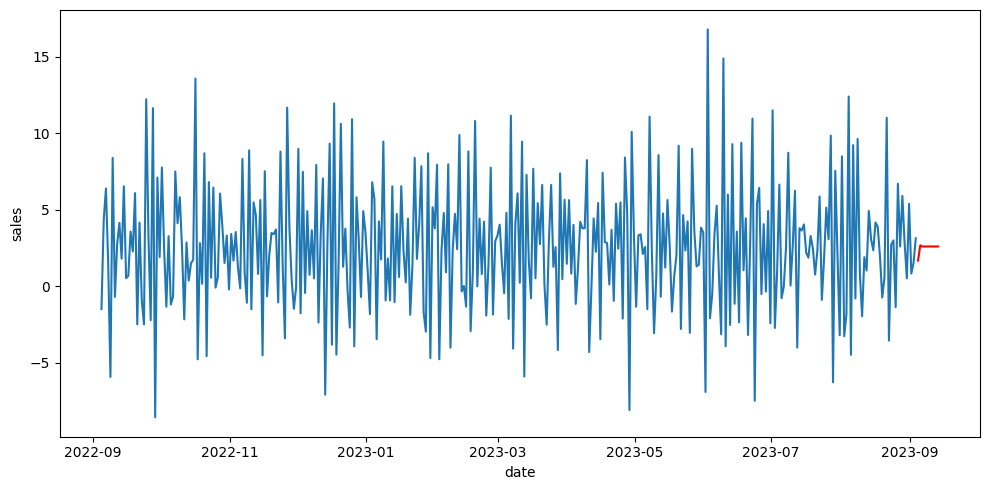

In [43]:
fig, axis = plt.subplots(figsize = (10, 5))

sns.lineplot(data = ts_stationary)
sns.lineplot(data = forecast, c = "red")

plt.tight_layout()

plt.show()

Voy a probar a comparar con la serie original y el parámetro seasonal a False.

In [51]:
model2 = auto_arima(ts, seasonal = False, trace = True, m = 12)


/home/vscode/.local/lib/python3.10/site-packages/pmdarima/arima/_validation.py:62: UserWarning: m (12) set for non-seasonal fit. Setting to 0
  warnings.warn("m (%i) set for non-seasonal fit. Setting to 0" % m)
/home/vscode/.local/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/vscode/.local/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/vscode/.local/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/vscode/.local/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be remove

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=1843.274, Time=0.41 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=2096.542, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=1970.972, Time=0.04 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=1839.586, Time=0.10 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=2209.657, Time=0.02 sec


/home/vscode/.local/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/vscode/.local/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/vscode/.local/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/vscode/.local/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/vscode/.local/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.

 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=1839.552, Time=0.21 sec


/home/vscode/.local/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=1841.532, Time=0.39 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=1843.586, Time=0.13 sec


/home/vscode/.local/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/vscode/.local/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=1839.607, Time=0.24 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=1922.648, Time=0.06 sec


/home/vscode/.local/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/vscode/.local/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,1,1)(0,0,0)[0]             : AIC=inf, Time=0.17 sec

Best model:  ARIMA(1,1,1)(0,0,0)[0] intercept
Total fit time: 1.789 seconds


Para este modelo no estacional los mejores parámetros son ARIMA(1,1,1)

In [52]:
model2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  366
Model:               SARIMAX(1, 1, 1)   Log Likelihood                -915.776
Date:                Thu, 06 Feb 2025   AIC                           1839.552
Time:                        17:04:21   BIC                           1855.152
Sample:                    09-03-2022   HQIC                          1845.752
                         - 09-03-2023                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      2.8110      0.134     21.055      0.000       2.549       3.073
ar.L1         -0.0821      0.052     -1.592      0.111      -0.183       0.019
ma.L1         -0.9413      0.020    -47.701      0.000      -0.980      -0.903
sigma2         8.7903      0.688     12.777      0.000       7.442      10.139
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):                 0.76
Prob(Q):                              1.00   Prob(JB):                         0.68
Heteroskedasticity (H):               0.90   Skew:                             0.07
Prob(H) (two-sided):                  0.58   Kurtosis:                         2.82
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [46]:
ts.index[-1]

Timestamp('2023-09-03 17:10:08.079328')

In [49]:
forecast2 = model.predict(10)
forecast2

/home/vscode/.local/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


2023-09-04 17:10:08.079328    1002.158148
2023-09-05 17:10:08.079328    1004.831668
2023-09-06 17:10:08.079328    1007.423289
2023-09-07 17:10:08.079328    1010.021630
2023-09-08 17:10:08.079328    1012.619419
2023-09-09 17:10:08.079328    1015.217253
2023-09-10 17:10:08.079328    1017.815084
2023-09-11 17:10:08.079328    1020.412915
2023-09-12 17:10:08.079328    1023.010746
2023-09-13 17:10:08.079328    1025.608577
Freq: D, dtype: float64

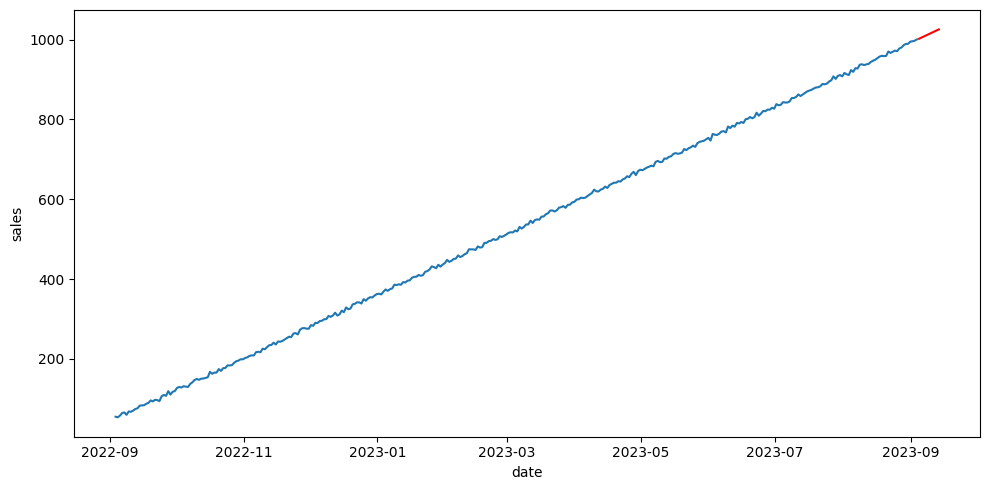

In [50]:
fig, axis = plt.subplots(figsize = (10, 5))

sns.lineplot(data = ts)
sns.lineplot(data = forecast2, c = "red")

plt.tight_layout()

plt.show()